# INFLAMeR

In [1]:
from collections import Counter
import yaml
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate, train_test_split)
import seaborn as sns
import xgboost as xgb
import shap
from src.utils import (print_training_results, plot_AUROC, plot_roc_cm, plot_AUPRC)

In [2]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input Data
The input data can be found, and download here: [zenodo link](https://zenodo.org/record/8114662)

In [3]:
df = pd.read_csv("../data/data.71.features.csv")
df.columns = df.columns.str.lower()
print(df.shape)
df.head()

(50847, 74)


,cell,gene,is antisense,locus is amplified,locus locus distance,log2 fpkm,near cancer associated snp,near fantom enhancer,near hnisz enhancer,near hnisz super enhancer,number of exons,tss pc distance,transcript length,within ctcf loop,within pol2 loop,has mouse ortholog,is intergenic,locus is heterozygous deleted,atf1,atf2,cbx3,cebpb,chd2,creb1,ctcf,e2f1,e2f6,egr1,elf1,ep300,esrra,fos,fosl1,foxm1,gabpa,gtf2f1,hcfc1,hdac1,ikzf1,irf1,jund,kdm5b,maff,mafk,maz,mta3,myc,ncor1,nfic,nr2c2,number of tfs,phf8,polr2a,rad21,rbbp5,rest,rnf2,sap30,sin3a,smarca4,sp1,spi1,srebf2,taf1,taf7,tbp,tead4,thap1,ubtf,yy1,zbtb33,zbtb7a,znf384,hit
0,K562,LH00001,0,0,43833,2.9612,0,0,0,0,2.5000,48473,"3,019.5000",0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,K562,LH00002,0,0,42685,-0.1795,0,0,0,0,2.0000,44966,609.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,K562,LH00004,0,0,0,-1.3535,1,0,0,0,2.0000,22062,582.0000,0,0,1,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,K562,LH00005,0,0,0,-1.0786,0,0,0,0,4.0000,7516,639.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,K562,LH00006,0,0,92687,-3.3219,0,0,0,0,2.0000,93681,295.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## 2) EDA

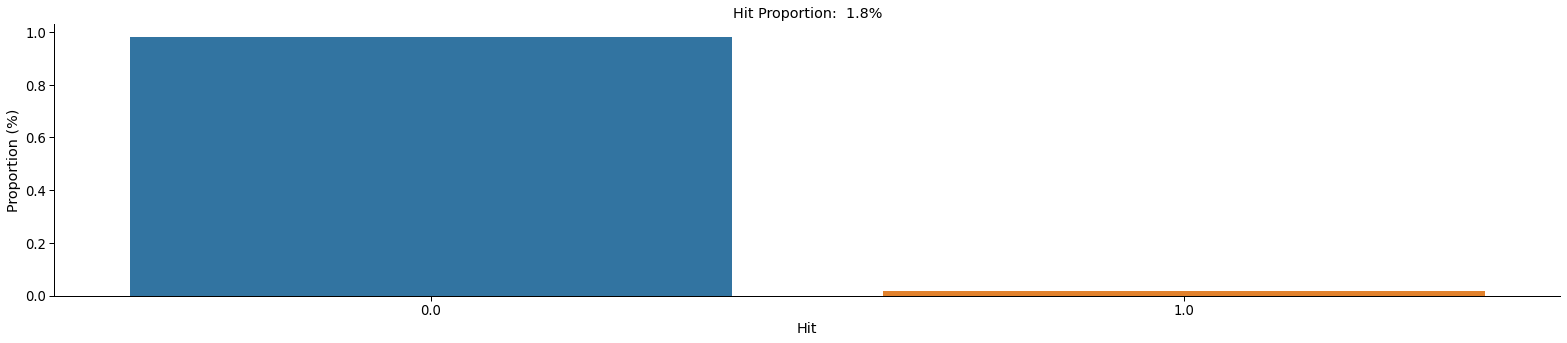

In [4]:
# Hit proportion
hit_prop = df["hit"].value_counts(dropna=False, normalize=True)\
                .reset_index().rename(columns={"index": "hit", "hit": "proportion"})
hit_proportion = hit_prop[hit_prop["hit"] == 1.0]["proportion"].values[0]

# Bar plot
sns.barplot(x=hit_prop["hit"], y=hit_prop["proportion"])

plt.ylabel("Proportion (%)")
plt.xlabel("Hit")
plt.title(f"Hit Proportion: {hit_proportion: .1%}")
plt.tight_layout()

## 3) Train XGBoost model

In [5]:
# Bring model configs
with open("config_files/config.yaml", "r") as file:
    config = yaml.safe_load(file)
    
SEED = config["SEED"]["seed"]
grid_search_results = config["MODEL"]

### 3.1) Train/Test split

In [6]:
X = df.drop(columns=["cell", "gene", "hit"]).copy(deep=True)
print(X.shape)
X.head()

(50847, 71)


,is antisense,locus is amplified,locus locus distance,log2 fpkm,near cancer associated snp,near fantom enhancer,near hnisz enhancer,near hnisz super enhancer,number of exons,tss pc distance,transcript length,within ctcf loop,within pol2 loop,has mouse ortholog,is intergenic,locus is heterozygous deleted,atf1,atf2,cbx3,cebpb,chd2,creb1,ctcf,e2f1,e2f6,egr1,elf1,ep300,esrra,fos,fosl1,foxm1,gabpa,gtf2f1,hcfc1,hdac1,ikzf1,irf1,jund,kdm5b,maff,mafk,maz,mta3,myc,ncor1,nfic,nr2c2,number of tfs,phf8,polr2a,rad21,rbbp5,rest,rnf2,sap30,sin3a,smarca4,sp1,spi1,srebf2,taf1,taf7,tbp,tead4,thap1,ubtf,yy1,zbtb33,zbtb7a,znf384
0,0,0,43833,2.9612,0,0,0,0,2.5000,48473,"3,019.5000",0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0,0,42685,-0.1795,0,0,0,0,2.0000,44966,609.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0,0,0,-1.3535,1,0,0,0,2.0000,22062,582.0000,0,0,1,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0,0,0,-1.0786,0,0,0,0,4.0000,7516,639.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0,0,92687,-3.3219,0,0,0,0,2.0000,93681,295.0000,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [7]:
y = df[['hit']].astype('int64').copy(deep=True)
num_classses = Counter(y.values.ravel())
print(num_classses)
y.head()

Counter({0: 49936, 1: 911})


,hit
0,0
1,0
2,0
3,0
4,0


### 3.2) ML training

In [8]:
%%time
# CV:
stratified_cv = RepeatedStratifiedKFold(n_splits=10, 
                                        n_repeats=3, 
                                        random_state= SEED)
# Scores
scoring = {"sensitivity": "recall", "f1_score": "f1", "precision": "precision", "auroc": "roc_auc"}

# XGBoost training
xgboost_model = xgb.XGBClassifier(**grid_search_results)
cv_results = cross_validate(xgboost_model, 
                            X, 
                            y.values.ravel(), 
                            cv= stratified_cv, 
                            scoring= list(scoring.values()), 
                            return_train_score= False, 
                            verbose=0)
# Print results
print_training_results(scoring_dict=scoring, input_model=xgboost_model, cv_results=cv_results)

----------
XGBClassifier mean-sensitivity: 0.7292 (+/-  0.04)
XGBClassifier mean-f1_score: 0.1275 (+/-  0.01)
XGBClassifier mean-precision: 0.0698 (+/-  0.00)
XGBClassifier mean-auroc: 0.8253 (+/-  0.02)
----------
CPU times: user 30.9 s, sys: 258 ms, total: 31.2 s
Wall time: 17.2 s


30it [00:17,  1.75it/s]


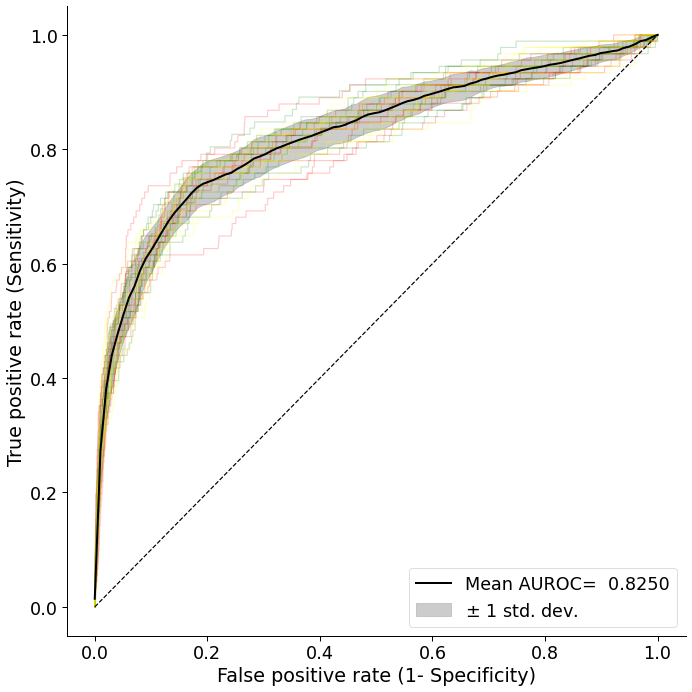

In [9]:
# Plot AUROC
plot_AUROC(model= xgboost_model, cv=stratified_cv, X=X, y=y)

30it [00:17,  1.76it/s]


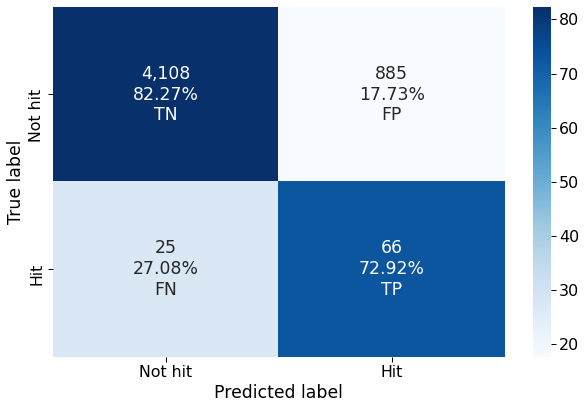

In [10]:
# Plot confussion matrix
plot_roc_cm(model= xgboost_model, cv= stratified_cv, X=X, y=y)

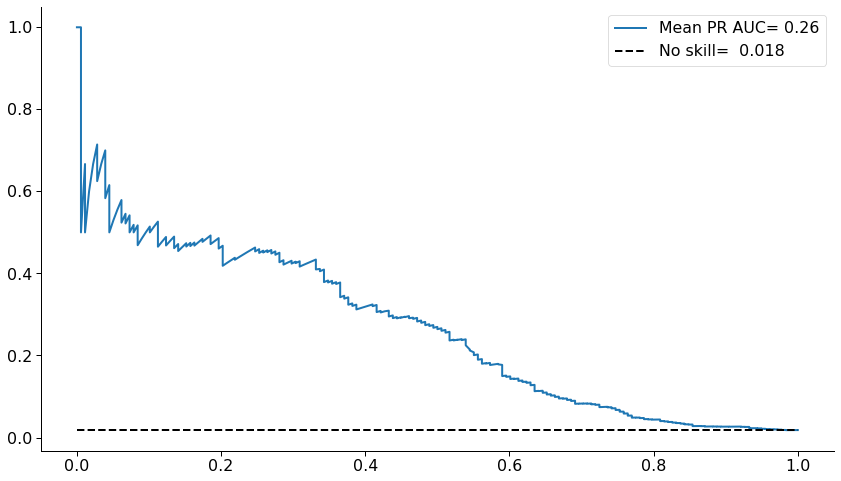

In [11]:
plot_AUPRC(model= xgboost_model, X=X, y=y)

### 3.3) Save model

In [12]:
# model_name = 'model/cs_xgb_71feat.pkl'

# with open(model_name, 'wb') as file:
#     pickle.dump(xgboost_model, file)

## 4) Model Explainability

In [13]:
X = pd.read_csv("../data/data.71.features.csv")\
        .drop(columns=["Cell", "Gene", "Hit"])\
        .rename(columns= {"Near hnisz enhancer": "Near traditional enhancer", 
                          "Log2 FPKM": "Expression level", 
                          "Near fantom enhancer": "Near FANTOM enhancer", 
                          "Near hnisz super enhancer": "Near super enhancer"})

xgboost_model = xgb.XGBClassifier(**grid_search_results)

for train, test in tqdm(stratified_cv.split(X, y.values.ravel())):
    X_train, y_train = X.iloc[train], y.iloc[train].values.ravel()
    X_test, y_test = X.iloc[test], y.iloc[test].values.ravel()
    xgboost_model.fit(X_train, y_train)

30it [00:16,  1.78it/s]


### 4.1) Global explainability

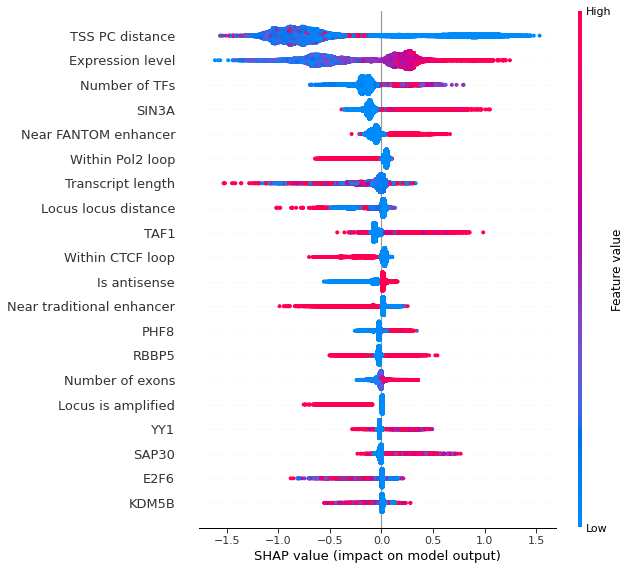

In [14]:
explainer = shap.TreeExplainer(model= xgboost_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.1, random_state=SEED)    

# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)

### 4.2) Explainability of the most importante feature

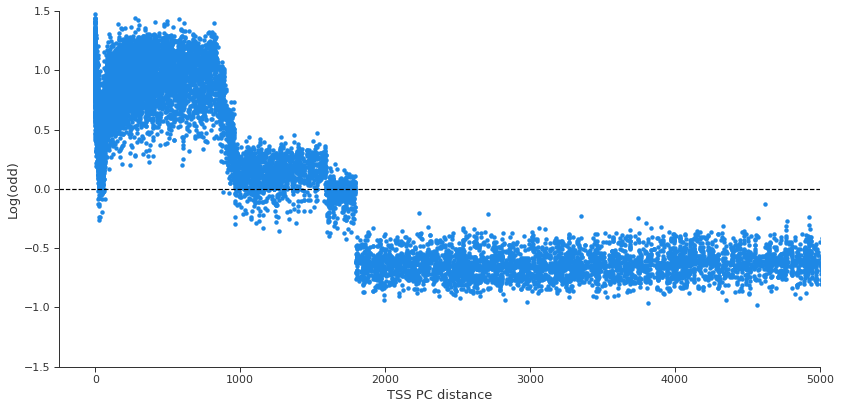

In [16]:
fig, axes= plt.subplots(nrows=1, ncols=1, figsize=(12,6))

shap.dependence_plot("TSS PC distance", shap_values, X, ax= axes, show= False, interaction_index= None, dot_size= 20, xmin=0, xmax=0.5e4)
axes.axhline(y=0, color="black", linestyle="dashed", lw=1.2)
axes.set_ylim(-1.5,1.5)
axes.set_ylabel("Log(odd)")

plt.tight_layout()

### 4.3) Local explainability of the lncRNA: LH15222

In [17]:
shap.initjs()

index_LH15222 = df[(df["cell"] == "K562") & (df["gene"] == "LH15222")].index
shap.force_plot(explainer.expected_value, shap_values[index_LH15222,:], X.iloc[index_LH15222,:], link= 'logit')

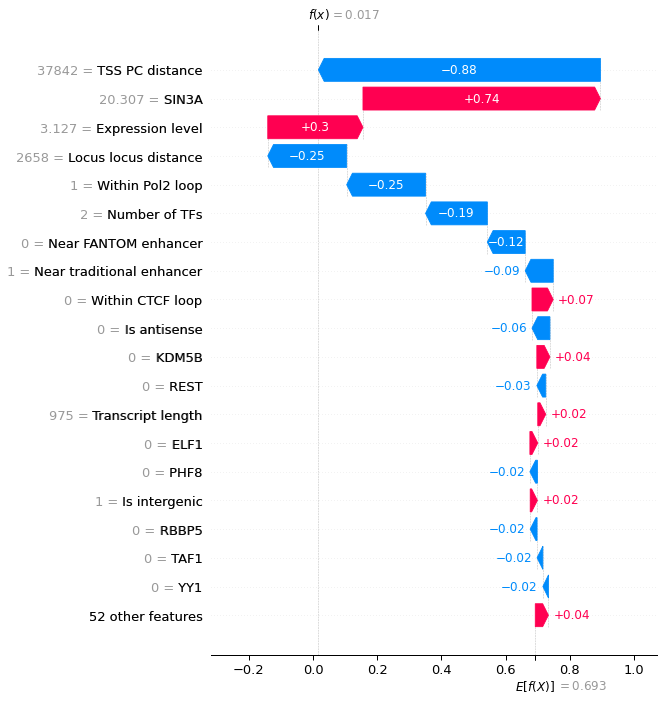

In [18]:
explainer = shap.Explainer(xgboost_model)
shap_values = explainer(X)

f = plt.figure()
shap.plots.waterfall(shap_values[index_LH15222[0]], max_display= 20)